# Why you should use Kriging

In this notebook, I will try to present various spatial estimation methods in multi-dimensions (here, for graphical needs, in dimension 2). My goal is to illustrate clearly how each works, his advantages and disadvantages. Lastly, I will present a method that I like very much : Kriging.

Note : this notebooks skips the entire theory behind each method. If you are curious, feel free to do some additional research.

I am trying to rely as few as possible on fancy packages, whose underlying code I am not sure of. Here are the tools you will need, which are some very common and widely used packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern #,DotProduct, WhiteKernel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import interp2d

## Introduction

Suppose we have a 3D surface with the following equation :

In [2]:
def branin(x,y,a=1,b=5.1/(4*np.pi**2),c=5/np.pi,r=6,s=10,t=1/(8*np.pi)):
    return a*(y-b*x**2+c*x-r)**2+s*(1-t)*np.cos(x)+s

Some of you who have read a bit about optimization (https://en.wikipedia.org/wiki/Test_functions_for_optimization) will recognize it as the Branin function. It is commonly used, as many other functions, to test some optimization algorithms, since it is very strangely shaped with a lot of local minima everywhere, and three global minima (http://www.sfu.ca/~ssurjano/branin.html).

Let's plot it to get a better idea. Please note that, throughout all this notebook, everytime I want to plot something I use the scatter function *on purpose*. This is because with continuous plotting, matplotlib *interpolates* between your points, and since we are trying to study different estimation methods, that would be very untrustworthy. However, if you put enough points, it will always appear to be continuous to the viewer, so that is not a problem.

In [3]:
X=np.linspace(-5,10,1500)
Y=np.linspace(0,15,1500)
points=[(x,y) for y in Y for x in X]

In [34]:
Z=[branin(x,y) for (x,y) in points]
m=max(Z)
colors=cm.rainbow([z/m for z in Z])

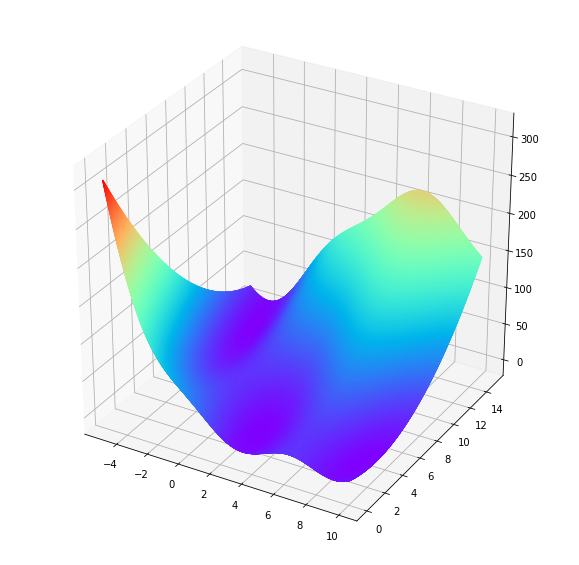

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points],Z, zdir='z', s=0.1, c=colors, depthshade=True)

Now, we will try various interpolation methods, to see which ones seem to approximate this function to the best. Let's randomly sample 100 points from our calculated points, and use them for fitting our interpolation. then we will try to recalculate all the others, and plot them.

In [7]:
coordinates=[(x,y,z) for x,y,z in zip(xs,ys,Z)]
init_points=np.random.choice(len(coordinates),100)
X,y=np.asarray([points[i] for i in init_points]),[Z[i] for i in init_points]
X_test,y_test=np.asarray([points[i] for i in range(len(coordinates)) if i not in init_points]),[Z[i] for i in range(len(coordinates)) if i not in init_points]
# small=np.random.choice([i for i in range(len(coordinates)) if i not in init_points],100)
# X_test_small,y_test_small=np.asarray([points[i] for i in small]),[Z[i] for i in small]

## Classical interpolation methods

### Linear interpolation

Let's start with the simplest of all methods : linear interpolation. It is very straightforward to implement using scipy (see here : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html).

In [29]:
def interpol_2d(kind):
    fun=interp2d([x[0]for x in X],[x[1] for x in X],y,kind=kind)
    return fun
linear=interpol_2d('linear')
Z_linear=[linear(x[0],x[1]) for x in X_test[::2]]
Z_linear=np.concatenate(Z_linear)

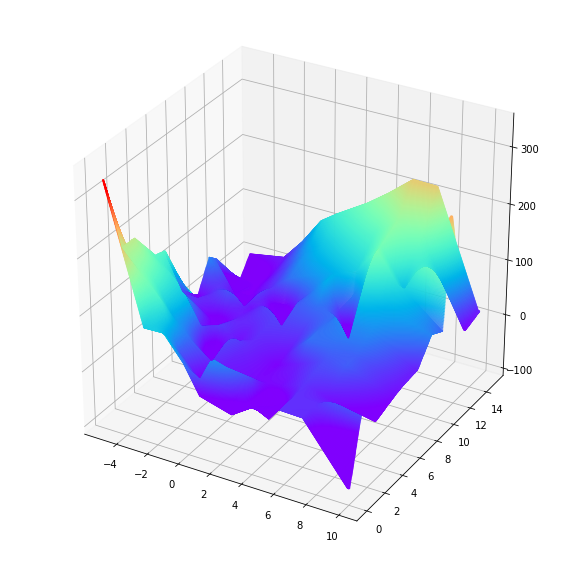

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_linear])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_linear, zdir='z', s=0.1, c=colors, depthshade=True)

We notice very well the "straightness" of linear interpolation : we can easily figure out where were the original points, and the curve is anything but smooth. It doesn't seem, in our case, a very appropriate interpolation method.

### Polynomial interpolation

A spline is a special function defined piecewise by polynomials. In interpolating problems, spline interpolation is often preferred to polynomial interpolation because it yields similar results, even when using low degree polynomials (from https://en.wikipedia.org/wiki/Spline_(mathematics)).

There are so many different types of polynomial interpolation that I will restrict myself to cubic splines (every piece is a polynomial of degree $\leq 3$).

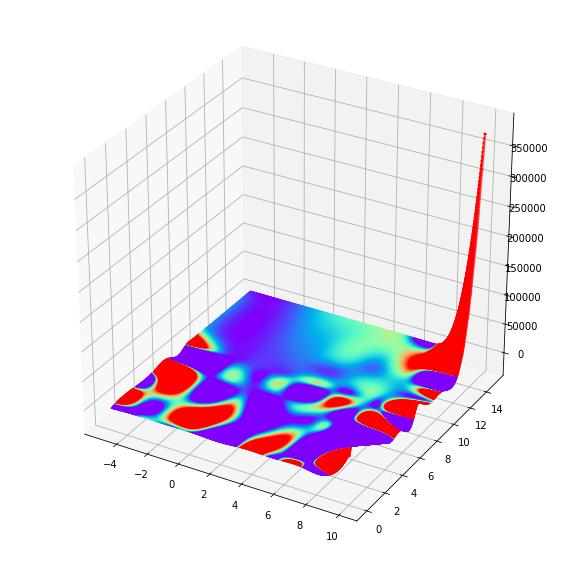

In [37]:
cubic=interpol_2d('cubic')
Z_cubic=[cubic(x[0],x[1]) for x in X_test[::2]]
Z_cubic=np.concatenate(Z_cubic)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_cubic])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_cubic, zdir='z', s=0.1, c=colors, depthshade=True)

Oh oh... What happened here ? Well, actually, this is a classical problem of polynomial interpolation (especially with a high degree, like cubic splines) : it explodes at the edges. If we set a maximum $z$ limit, we will see better :

(0, 300)

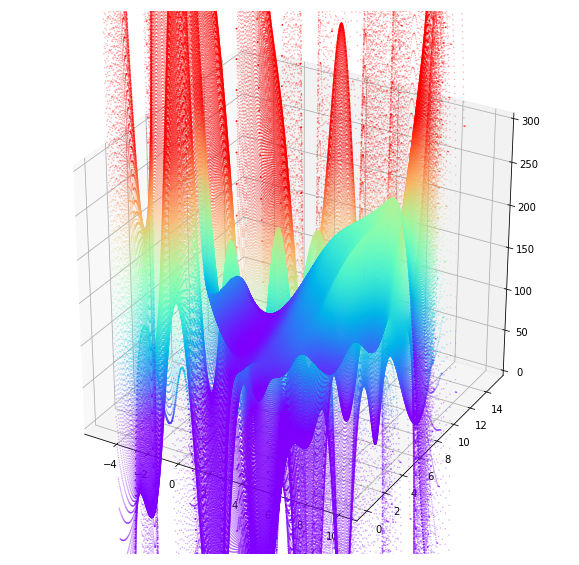

In [38]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_cubic])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_cubic, zdir='z', s=0.1, c=colors, depthshade=True)
ax.set_zlim(0, 300)

Oh oh... Definitely not a good idea, those splines.

## Other methods

Here I present 2 methods who are not strictly speaking interpolation methods, but still widely used for space estimation.

### K-nearest-neighbors

I encourage you to test different values of n_neighbors, to see the difference in results. However, the conclusion remaines the same.

In [18]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)
Z_knn=neigh.predict(X_test[::2])

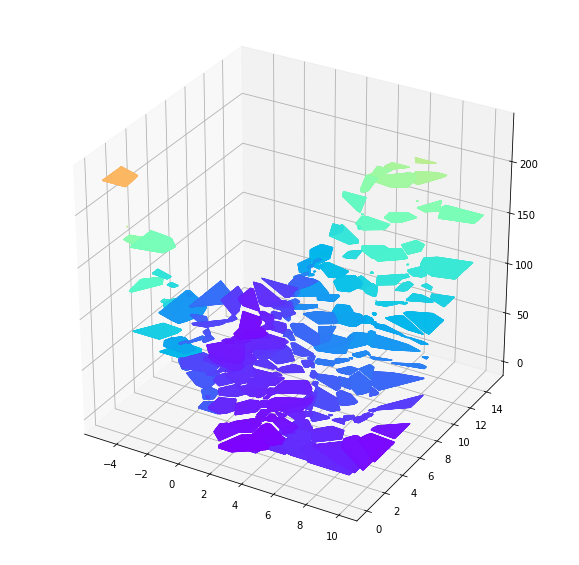

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_knn])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_knn, zdir='z', s=0.1, c=colors, depthshade=True)

We see here very well the fundamental property of k-nn : you can only take 100 Z-values, the ones from the initial points. You cannot get a continuous prediction. We very clearly see the patches surrounding the 100 original points, into which the data is approximated by the value at the central point.

### Random Forest Regression

Here as well, you can try various values for the number of trees, the maximal depth, or the metric.

In [19]:
regr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=100, random_state=0)
regr.fit(X, y)
Z_randforest=regr.predict(X_test[::2])

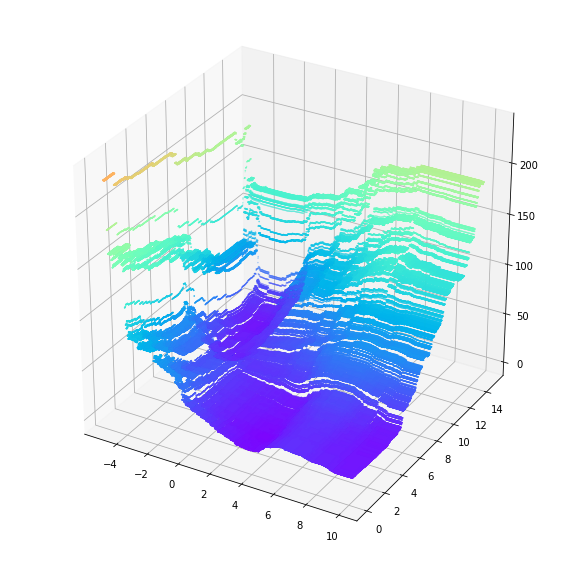

In [40]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_randforest])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_randforest, zdir='z', s=0.1, c=colors, depthshade=True)

Interestingly, we notice here a property of trees : we can see the presence of kind of strays, which are in fact linked to tree branches used in the attribution of value. They define "ranges" of values into which the attributed target is constant.

## Kriging

Here at last, I come to the most interesting part of this notebook ! For those of you who never heard about kriging, I recommend you to start with some theory.

Kriging is a very interesting and powerful interpolation methods, that can be used for various purposes : interpolation, smoothing (like presented here), but also in sequential experiments, in contexts of fixed calculation budgets (more detailed notebook on this subject coming soon), since it presents the advantage to estimate its own standard error in every point of space.

Useful links :  \begin{itemize}
\item https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process
\item https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor
\end{itemize}



I you didn't know (I didn't until quite recently), in lots of packages Kriging is actually called Gaussian Process Regressor.

In [41]:
kernel=Matern(length_scale=1,nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y)
print(gpr.score(X, y))

1.0


We get a score of 1, which is natural : kriging is an exact interpolation method. Like previously, I encourage you to try different kernels to see the results. There is not one perfect kernel for every function : the choice of kernel depends on what you are trying to estimate.

In [ ]:
# a=gpr.predict(X_test_small, return_std=False)
# b=y_test_small
# print(np.linalg.norm(a-b))

In [42]:
Z_krig=gpr.predict(X_test[::2], return_std=False)

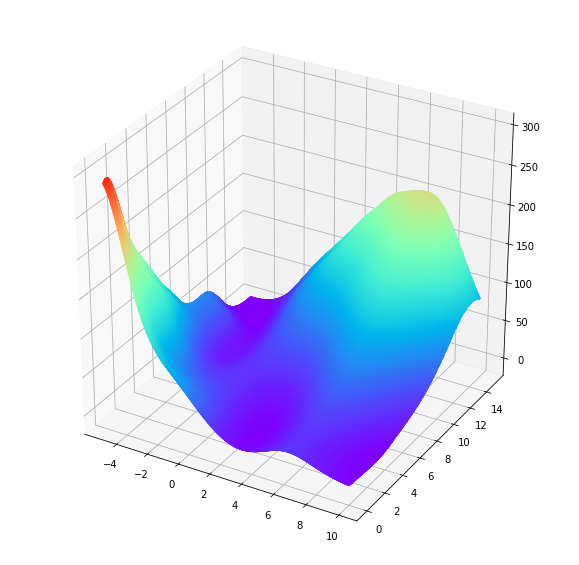

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_krig])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_krig, zdir='z', s=0.1, c=colors, depthshade=True)

Wow, so beautiful, so smooth ! And definitely much alike the original function. However, if you watch carefully, you can still notice areas where it is not very well estimated (for example the back corner). It still seems to be, by far, the best method so far.

 Let's take advantage of the kriging property of giving access to error, to see in which area the estimation is poorer :

In [47]:
Z_error=gpr.predict(X_test[::2], return_std=True)

In [51]:
Z_error=Z_error[1]

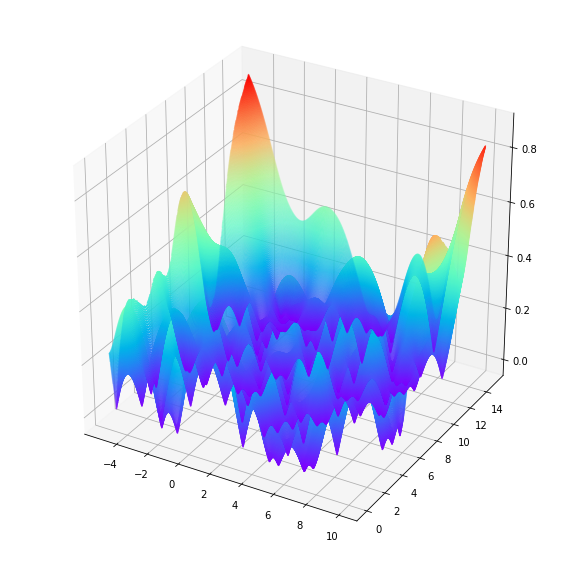

In [52]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
mm=max(Z_error)
colors=cm.rainbow([z/mm for z in Z_error])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_error, zdir='z', s=0.1, c=colors, depthshade=True)

Like expected, the loss is particularly high in the back corner, but globally when you look at its range of values, it stays rather low compared to other methods.

## Conclusion

I don't want you to conclude from this notebook that you should always use Kriging, and that the other methods never work. Actually, there isn't one perfect method for every estimation problem. Please note that the function I have chosen, the Branin function, is a very peculiar function, often studied for its uncommon properties, that was a perfect example for this notebook. But on most simpler functions, the other methods can work as well, and sometimes even better than Kriging !

Coming soon, in another notebook : using kriging for sequential simulations...